# Lake model

see also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

## the lake model
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural removal rate, $q$ is the lake's natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## Assignment
1. Given the Python implementation of the lake problem in lakemodel_function.py, adapt this code and connect it to the workbench

for the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1. Carefully look at line 23 in lake_model.py to identify the name to use for each lever.




2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


In [10]:
RealParameter('l0', 0, 0.1) #hello

RealParameter('l0', 0, 0.1)

In [4]:
# [RealParameter('l' + str(i), 0, 0.1) for i in range(100)]

In [ ]:
import numpy as np
from lakemodel_function import lake_problem
from ema_workbench import (RealParameter, ScalarOutcome, Constant, Model)
import pandas as pd
import plotly_express as px
import seaborn as sns

In [45]:
# model = ReplicatorModel('lakeproblem', function=lake_problem)
model = Model('lakeproblem', function=lake_problem)
# model.replications = 150

# model.levers = [RealParameter('l' + str(i), 0, 0.1) for i in range(100)]
 
#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
# set levers
#specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

In [47]:
%%time
from ema_workbench import (SequentialEvaluator, ema_logging, perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)
 
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=0)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


Wall time: 1min 16s


[MainProcess/INFO] no time dimension found in results


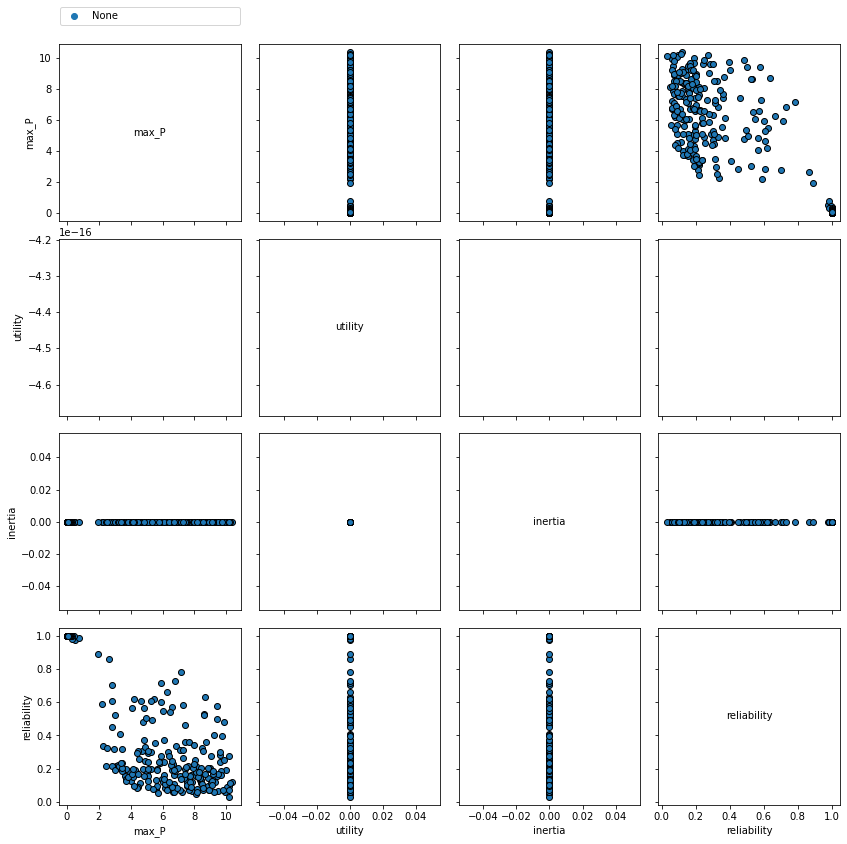

In [52]:
from ema_workbench.analysis import pairs_plotting
import matplotlib.pyplot as plt

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy")

fig.set_size_inches(14,14)

plt.show()

In [93]:
outcomes_df.columns

Index(['max_P', 'utility', 'inertia', 'reliability'], dtype='object')

In [96]:
experiments.columns

Index(['b', 'delta', 'mean', 'q', 'stdev', 'l0', 'l1', 'l2', 'l3', 'scenario',
       'policy', 'model'],
      dtype='object')

In [100]:
experiments

,b,delta,mean,q,stdev,l0,l1,l2,l3,scenario,policy,model
0,0.177687,0.985302,0.018786,3.591123,0.002186,0.060794,0.010014,0.024730,0.065358,6000,13,lakeproblem
1,0.285937,0.970773,0.012666,4.198380,0.002472,0.060794,0.010014,0.024730,0.065358,6001,13,lakeproblem
2,0.323216,0.936899,0.040129,2.501516,0.001072,0.060794,0.010014,0.024730,0.065358,6002,13,lakeproblem
3,0.349536,0.974058,0.015370,2.027662,0.003255,0.060794,0.010014,0.024730,0.065358,6003,13,lakeproblem
4,0.301403,0.966765,0.029340,3.057614,0.004581,0.060794,0.010014,0.024730,0.065358,6004,13,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.324595,0.934480,0.038423,3.172539,0.001099,0.077411,0.085019,0.055498,0.041454,6995,16,lakeproblem
3996,0.296614,0.948042,0.034931,2.670097,0.001475,0.077411,0.085019,0.055498,0.041454,6996,16,lakeproblem
3997,0.245427,0.946465,0.022999,3.120482,0.002061,0.077411,0.085019,0.055498,0.041454,6997,16,lakeproblem
3998,0.310725,0.975070,0.028528,3.318986,0.004940,0.077411,0.085019,0.055498,0.041454,6998,16,lakeproblem


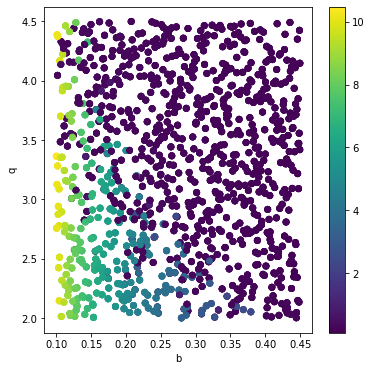

In [102]:
P = outcomes['max_P']
# max_P = np.max(I, axis=1)

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.b, experiments.q, c=P)
plt.colorbar(sc)
ax.set_xlabel('b')
ax.set_ylabel('q')
plt.show()

In [104]:
experiments.columns

Index(['b', 'delta', 'mean', 'q', 'stdev', 'l0', 'l1', 'l2', 'l3', 'scenario',
       'policy', 'model'],
      dtype='object')

In [109]:
experiments["mean"].dropna(inplace=True)

In [113]:
experiments["mean"]

0       0.018786
1       0.012666
2       0.040129
3       0.015370
4       0.029340
          ...   
3995    0.038423
3996    0.034931
3997    0.022999
3998    0.028528
3999    0.038178
Name: mean, Length: 4000, dtype: float64

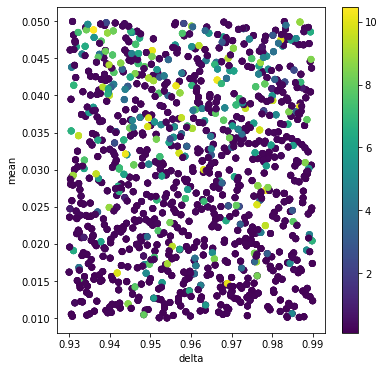

In [114]:
P = outcomes['max_P']
# max_P = np.max(I, axis=1)

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.delta, experiments["mean"], c=P)
plt.colorbar(sc)
ax.set_xlabel('delta')
ax.set_ylabel('mean')
plt.show()

In [59]:
# model = ReplicatorModel('lakeproblem', function=lake_problem)
model = Model('lakeproblem', function=lake_problem)
# model.replications = 150

model.levers = [RealParameter('l' + str(i), 0, 0.1) for i in range(4)]
 
#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
# set levers
#specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

In [60]:
%%time
from ema_workbench import (SequentialEvaluator, ema_logging, perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)
 
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Wall time: 4min 20s


3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

### Why does changing the number of levers change how the results show up?

In [89]:
outcomes_df = pd.DataFrame.from_dict(outcomes)
melted = pd.melt(outcomes_df, value_vars = outcomes_df.columns)

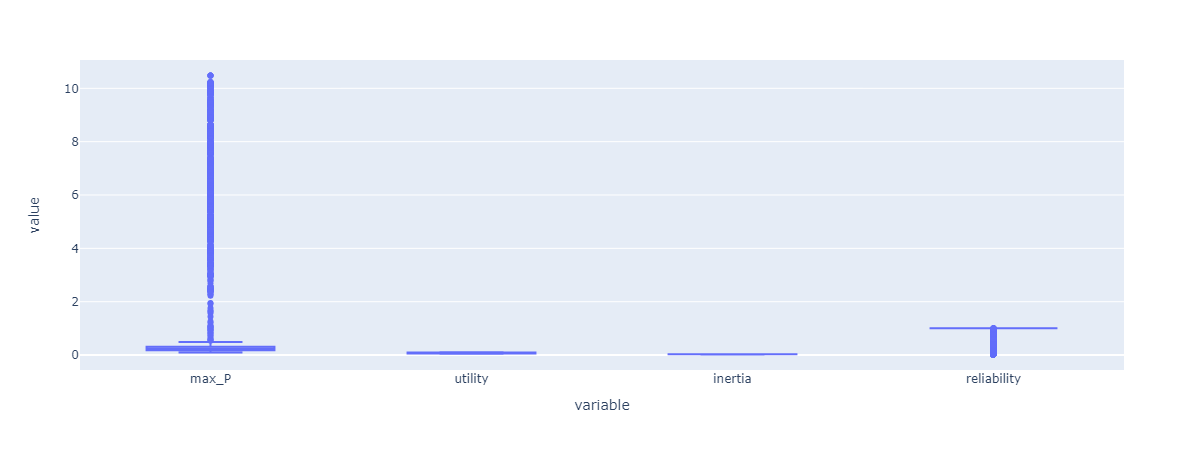

In [90]:
px.box(melted, y ="value", x="variable")

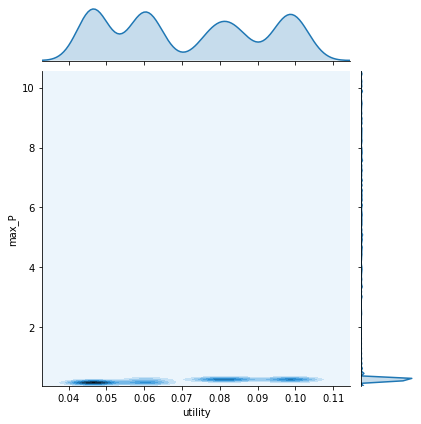

In [91]:
sns.jointplot(data=outcomes_df, y="max_P", x="utility", kind='kde')

C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:514: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\matplotlib\contour.py:1483: UserWarning:


C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\matplotlib\contour.py:1484: UserWarning:


C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\matplotlib\contour.py:1132: RuntimeWarning:

invalid value encountered in less

C:\Users\jryap\anaconda3\envs\geo_env\lib\site-packages\matplotlib\contour.py:1134: RuntimeWarning:

invalid value encountered in greater



RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

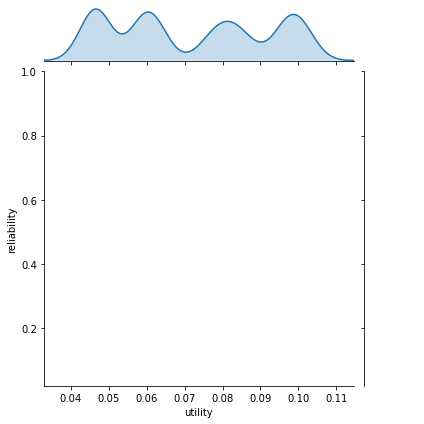

In [92]:
sns.jointplot(data=outcomes_df, y="reliability", x="utility", kind='kde')

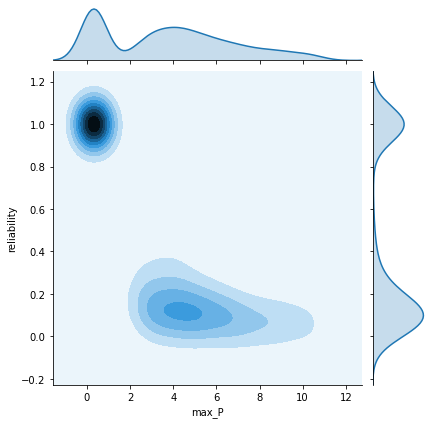

In [88]:
sns.jointplot(data=outcomes_df, y="reliability", x="max_P", kind='kde')

In [86]:
experiments.l3.unique()

array([0.06535773, 0.09603641, 0.00084612, 0.0414541 ])

In [87]:
experiments.sort_values(by="scenario").head(20)

,b,delta,mean,q,stdev,l0,l1,l2,l3,scenario,policy,model
0,0.177687,0.985302,0.018786,3.591123,0.002186,0.060794,0.010014,0.024730,0.065358,6000,13,lakeproblem
1000,0.177687,0.985302,0.018786,3.591123,0.002186,0.002042,0.028668,0.096172,0.096036,6000,14,lakeproblem
3000,0.177687,0.985302,0.018786,3.591123,0.002186,0.077411,0.085019,0.055498,0.041454,6000,16,lakeproblem
2000,0.177687,0.985302,0.018786,3.591123,0.002186,0.030757,0.055372,0.034306,0.000846,6000,15,lakeproblem
3001,0.285937,0.970773,0.012666,4.198380,0.002472,0.077411,0.085019,0.055498,0.041454,6001,16,lakeproblem
1001,0.285937,0.970773,0.012666,4.198380,0.002472,0.002042,0.028668,0.096172,0.096036,6001,14,lakeproblem
1,0.285937,0.970773,0.012666,4.198380,0.002472,0.060794,0.010014,0.024730,0.065358,6001,13,lakeproblem
2001,0.285937,0.970773,0.012666,4.198380,0.002472,0.030757,0.055372,0.034306,0.000846,6001,15,lakeproblem
1002,0.323216,0.936899,0.040129,2.501516,0.001072,0.002042,0.028668,0.096172,0.096036,6002,14,lakeproblem
3002,0.323216,0.936899,0.040129,2.501516,0.001072,0.077411,0.085019,0.055498,0.041454,6002,16,lakeproblem


[MainProcess/INFO] no time dimension found in results


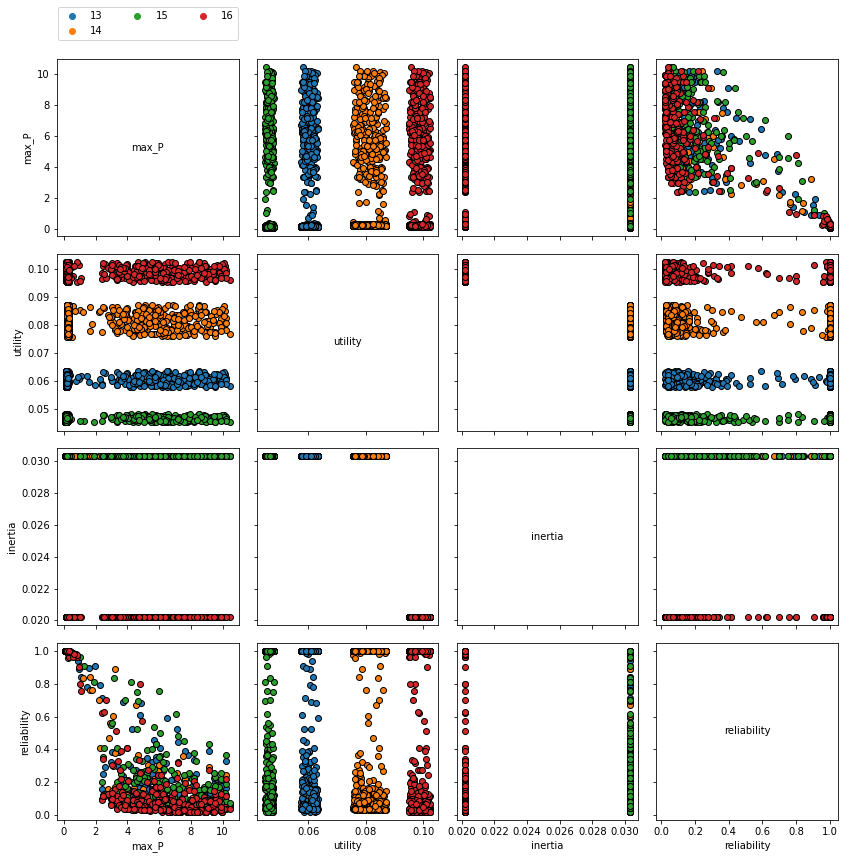

In [84]:
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy")

fig.set_size_inches(14,14)

plt.show()

In [82]:
# model = ReplicatorModel('lakeproblem', function=lake_problem)
model = Model('lakeproblem', function=lake_problem)
# model.replications = 150

model.levers = [RealParameter('l' + str(i), 0, 0.1) for i in range(4)]
 
#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
# set levers
#specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

In [83]:
%%time
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 1min 36s


[MainProcess/INFO] no time dimension found in results


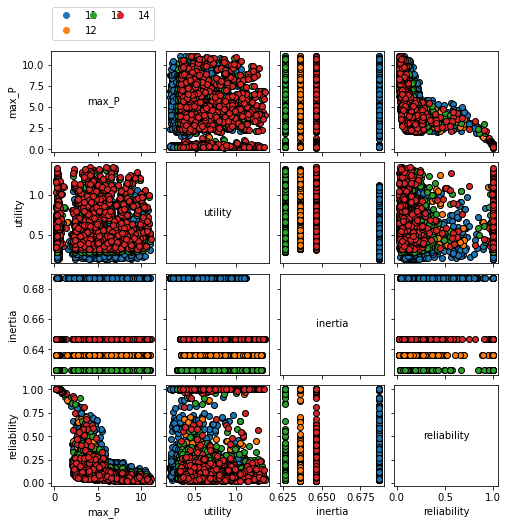

In [27]:
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy")

fig.set_size_inches(8,8)

plt.show()

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each? Adapt your code from above and sue the `MultiProcessingingEvaluator`. Use the time library to check how much faster the computation for 1000 scenarios completes. 

Using multiprocessing within a jupyter notebook is tricky. On linux it will work in general just fine. On mac it depends on the version of Mac OS and the version of Python. If you are on the latest version of Mac OS in combination with Python 3.8, it might work but no guarantees. On older versions of Python it should work fine. On Windows it is always a problem. 

The underlying explanation is quite technical. It has to do with how your operating system creates the additional python processes. On windows, and the latest version of Mac OS in combination with Python 3.8. A completely new Python process is spawned. This new process does **not** inherit what is defined in memory of the parent process. The new child process will try to replicate what is in memory of the parent process by executing many of the import statements that have also been executed within the python process. Thus, if you define a model in the main process, it is not guaranteed to be known in the child processes. This is in particular true if you define the model within a jupyter notebook. Then the child processes will **never** know this function. Within jupyter notebooks, therefore, the best practice is to define your model within a .py file and import this .py file into the notebook. Now, each of the child processes will also execute this import statement and thus know the function. 


In [28]:
ema_logging.log_to_stderr(ema_logging.INFO)
 
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
